In [ ]:
import os
os.mkdir("data")

In [1]:
# mount your gdrive folder
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
#required librairies to extract .7z
!pip install pyunpack
!pip install patool

In [ ]:
from pyunpack import Archive
Archive('/content/drive/My Drive/data/final/data_total_split_updated.7z').extractall('/content/data' )

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:

# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:

# Register a dataset in COCO’s json annotation format for instance detection, instance segmentation and keypoint detection. 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("myDataset_train", {}, "/content/data/data_total_split_updated/train/train_coco.json", "/content/data/data_total_split_updated/train")
register_coco_instances("myDataset_val", {}, "/content/data/data_total_split_updated/val/val_coco.json", "/content/data/data_total_split_updated/val")
#register the test dataset
register_coco_instances("myDataset_test", {}, "/content/data/data_total_split_updated/test/test_coco.json", "/content/data/data_total_split_updated/test")


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

papers_metadata = MetadataCatalog.get("myDataset_train") #return the Metadata instance associated with this name
dataset_dicts = DatasetCatalog.get("myDataset_train") # Call the registered function and return dataset annotations


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



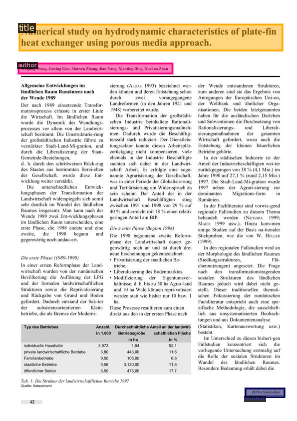

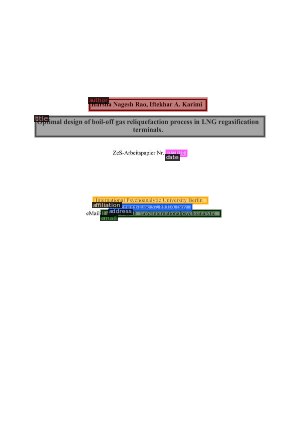

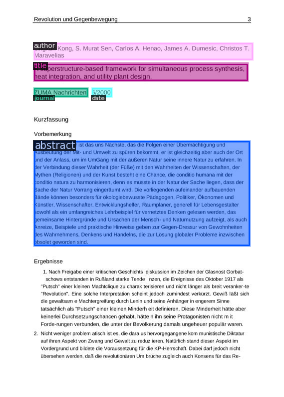

In [ ]:
# take a look at the data to see if the images are loaded correctly
from google.colab.patches import cv2_imshow
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=papers_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
import os
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create the output dir for the trained model
output_dir = os.path.join("/content/drive/My Drive/output", datetime.datetime.now().strftime('%Y%m%dT%H%M'))
os.makedirs(output_dir, exist_ok=True)
# change the config in the .yaml document
cfg = cfg = get_cfg() #load default config
cfg.merge_from_file("/content/drive/My Drive/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.OUTPUT_DIR = output_dir #change the output path
cfg.DATASETS.TRAIN = ("myDataset_train",) #specify the trainning dataset
cfg.DATASETS.TEST = ()
BASE_LR: 0.0025
STEPS: [0, 7500, 10000]
cfg.SOLVER.MAX_ITER = 15000
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/model_final_trimmed.pth"  # load intial weights from the pre-trained model in publaynet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9 
cfg.MODEL.BACKBONE.FREEZE_AT= 2 #freeze the stem and 1 backbone layers
#serialize the training config
cfg_str = cfg.dump()
with open(os.path.join(cfg.OUTPUT_DIR, "train_config.yaml"), "w") as f:  #write the new config in the 'train_config.yaml'
  f.write(cfg_str)
f.close()

# using hpanwar08's trainer specified in the cell above
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Config '/content/drive/My Drive/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[09/01 13:06:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in 

[09/01 13:06:40 d2.engine.train_loop]: Starting training from iteration 0
[09/01 13:06:51 d2.utils.events]:  eta: 2:05:21  iter: 19  total_loss: 4.008  loss_cls: 2.298  loss_box_reg: 0.740  loss_mask: 0.688  loss_rpn_cls: 0.123  loss_rpn_loc: 0.186  time: 0.4975  data_time: 0.0170  lr: 0.000018  max_mem: 5572M
[09/01 13:07:01 d2.utils.events]:  eta: 2:06:02  iter: 39  total_loss: 3.828  loss_cls: 2.084  loss_box_reg: 0.769  loss_mask: 0.678  loss_rpn_cls: 0.080  loss_rpn_loc: 0.173  time: 0.4973  data_time: 0.0080  lr: 0.000036  max_mem: 5572M
[09/01 13:07:11 d2.utils.events]:  eta: 2:07:42  iter: 59  total_loss: 3.412  loss_cls: 1.634  loss_box_reg: 0.765  loss_mask: 0.654  loss_rpn_cls: 0.145  loss_rpn_loc: 0.195  time: 0.5056  data_time: 0.0058  lr: 0.000054  max_mem: 5572M
[09/01 13:07:21 d2.utils.events]:  eta: 2:06:42  iter: 79  total_loss: 2.812  loss_cls: 1.119  loss_box_reg: 0.787  loss_mask: 0.622  loss_rpn_cls: 0.079  loss_rpn_loc: 0.213  time: 0.5030  data_time: 0.0083  lr:

In [ ]:
print(output_dir)

/content/drive/My Drive/output/20200901T1306
